In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
from oaatutils import *
import geopandas as gpd
from shapely.geometry import *

In [3]:
def byhand(t,p):
    # heuristic for assigning biomes to points outside of polygons
    t1 = -5  #    tundra-boreal
    t2 =  3  #    boreal-temperate
    t3 = 20  # temperate-tropical

    tvals = [-np.inf,t1,t2,t3,np.inf]
    bvals = [9,8,4,1]


    for i in range(4):
        if (t>tvals[i])&(t<=tvals[i+1]):
            b = bvals[i]

    td = 15; pd=60; bd=3  #desert
    if (t>td)&(p<pd):
        b = bd

    return b

In [49]:
#read in vectors defining the whittaker biomes (for plotting)
df = pd.read_csv('./whit/Whittaker_biomes.csv')

#and the original shape file
fp = './whit/Whittaker_biomes.shp'
data = gpd.read_file(fp)

In [50]:
#a bunch of extra work to get the legend in an order that I prefer
og   = data.biome_id.copy(deep=True).values
newb = np.array([9,8,7,6,5,4,1,2,3])
data.biome_id=newb #more logical order
df0 = pd.read_csv('./whit/Whittaker_biomes.csv')
x  = df.biome_id.values 
for i in 1+np.arange(9):
    ix = df0.biome_id==i
    b  = newb[og==i]
    x[ix]=b
df.biome_id=x

In [47]:
#read in the climate data and time-average
d='/glade/campaign/cgd/tss/projects/PPE/PPEn11_OAAT/CTL2010/hist/'
f='PPEn11_CTL2010_OAAT0000.clm2.h0.2005-02-01-00000.nc'
ds=fix_time(xr.open_dataset(d+f))
tbot=amean(ds.TBOT).mean(dim='year')-273.15 #degC
gpp=24*60*60*365*amean(ds.GPP).mean(dim='year') #gC/m2/yr
rain=24*60*60*365/10*amean(ds.RAIN).mean(dim='year') #cm/yr
snow=24*60*60*365/10*amean(ds.SNOW).mean(dim='year') #cm/yr
prec=rain+snow

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [48]:
#determine the biome of each gridcell
bclass = np.zeros(400)+np.nan
for i in range(400):
    if (tbot[i]<0)&(gpp[i]==0):
        bclass[i]=0  #ice
    else:
        ptf = gpd.GeoDataFrame({'geometry':[Point(tbot[i],prec[i])]})
        x=gpd.overlay(ptf, data, how='intersection')
        if len(x)>0:
            bclass[i] = x.biome_id.values
        else:
            bclass[i] = byhand(tbot[i],prec[i])


In [51]:
#my preferred line colors
c = np.zeros([10,3])
c[1,:] = [9,91,31]
c[2,:] = [171,215,102]
c[3,:] = [218,203,111]
c[4,:] = [29,196,130]
c[5,:] = [136,246,72]
c[6,:] = [205,108,60]
c[7,:] = [245,245,159]
c[8,:] = [91,56,9]
c[9,:] = [160,211,216]
c = c/256

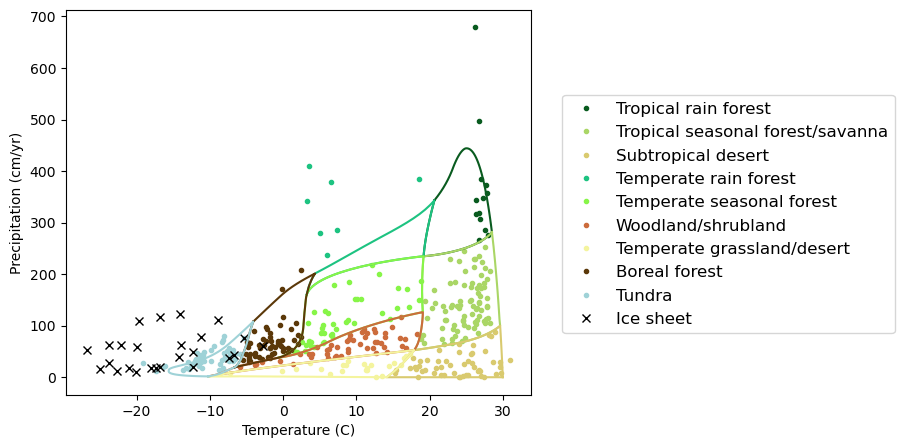

In [98]:
fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(111)
biomes = np.unique(df.biome_id.values)
ll=[]
for i in 1+np.arange(9):
    ix = bclass==i
    plt.plot(tbot[ix],prec[ix],'.',color=c[i,:])
    ll.append(data.biome[data.biome_id==i].values[0])

ix = bclass==0
plt.plot(tbot[ix],prec[ix],'kx')
ll.append('Ice sheet')

    
plt.legend(ll,bbox_to_anchor = (1.05, 0.8),fontsize=12)
for i in 1+np.arange(9):
    ix = df.biome_id==i
    t = df.temp_c[ix]
    p = df.precp_cm[ix]
    plt.plot(t,p,'-',color=c[i,:])

plt.xlabel('Temperature (C)')
plt.ylabel('Precipitation (cm/yr)');
plt.savefig('../figs/supp/biome_tp.png',dpi=300,bbox_inches='tight')

In [53]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap

In [85]:
sg=xr.open_dataset('clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc')
lnd=sg.landfrac_orig>0
lons=xr.DataArray(ds.grid1d_lon.values,dims='lon')
lats=xr.DataArray(ds.grid1d_lat.values,coords=[lons])

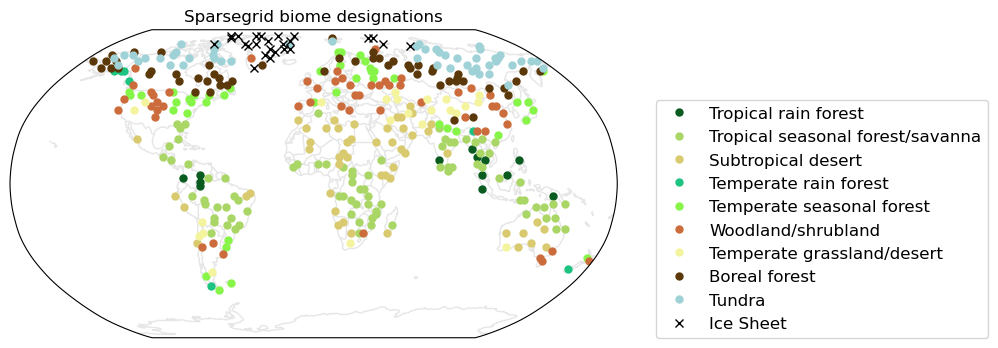

In [100]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
cmap=ListedColormap(0.8*np.ones(3))
#mappable = lnd.where(lnd).plot(transform=ccrs.PlateCarree(),ax=ax,add_colorbar=False,cmap=cmap)
ax.add_feature(cfeature.BORDERS,edgecolor=[0.9,0.9,0.9]);
ax.add_feature(cfeature.COASTLINE,edgecolor=[0.9,0.9,0.9])
ax.set_global()

for i in 1+np.arange(9):
    ix = bclass==i
    lats.isel(lon=ix).plot.line('.',transform=ccrs.PlateCarree(),ax=ax,color=c[i,:],ms=10,
                                label=data.biome[data.biome_id==i].values[0])
ix = bclass==0
lats.isel(lon=ix).plot.line('kx',transform=ccrs.PlateCarree(),ax=ax,
                            label='Ice Sheet')
plt.legend(bbox_to_anchor = (1.05, 0.8),fontsize=12)
ax.set_title('Sparsegrid biome designations');
plt.savefig('../figs/supp/biome_latlon.png',dpi=300,bbox_inches='tight')

In [107]:
la=xr.open_dataset('sparsegrid_landarea.nc').landarea
whit=xr.open_dataset('./whit/whitkey.nc')

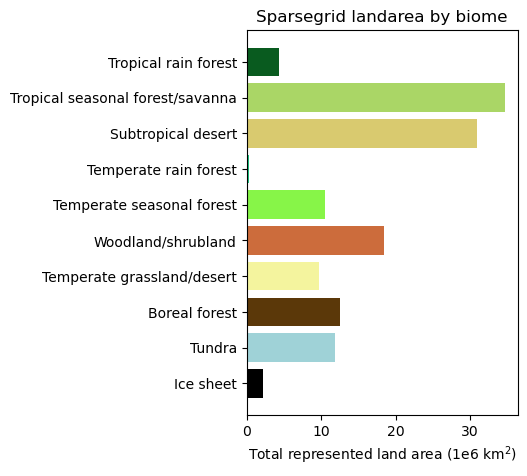

In [147]:
plt.figure(figsize=[3.5,5])
bareas=la.groupby(whit.biome).sum()
order=[*np.arange(9)+1,0]
for i,j in enumerate(order):
    plt.barh(9-i,bareas[j]/1e6,color=c[j,:])
plt.yticks(range(9,-1,-1),whit.biome_name[order].values)
plt.xlabel('Total represented land area (1e6 km$^2$)')
plt.title('Sparsegrid landarea by biome');
plt.savefig('../figs/supp/biome_areas.png',dpi=300,bbox_inches='tight')

### save to netcdf

In [234]:
ds_out = xr.Dataset()

In [235]:
da = xr.DataArray(bclass,coords={'gridcell':ds.gridcell})

In [236]:
ds_out['biome']=da
for v in ['grid1d_lat','grid1d_lon']:
    ds_out[v]=ds[v]

In [237]:
ds_out

<xarray.Dataset>
Dimensions:     (gridcell: 400)
Coordinates:
  * gridcell    (gridcell) int64 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399
Data variables:
    biome       (gridcell) float64 5.0 4.0 5.0 5.0 7.0 ... 0.0 0.0 0.0 0.0 0.0
    grid1d_lat  (gridcell) float64 ...
    grid1d_lon  (gridcell) float64 ...

In [238]:
b_ids  = 1+np.arange(9)
bnames = [data.biome[data.biome_id==i].values[0] for i in b_ids]
b_ids  = [0,*b_ids]
bnames = ['Ice sheet',*bnames]
da = xr.DataArray(bnames,coords={'biome_id':b_ids})

In [239]:
ds_out['biome_name']=da

In [242]:
ds_out.to_netcdf('whit/whitkey.nc')